In [1]:
# Data wrangling
import pandas as pd
import numpy as np
# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
# Off FutureWarnings
import warnings 
warnings.filterwarnings('ignore')
#Resampling
from imblearn.over_sampling import SMOTENC 
from sklearn.utils import class_weight
#Dimension Reduction
from sklearn.decomposition import PCA
# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
# Save model
import pickle

In [2]:
## Upload df
df = pd.read_csv('cleaned_data.csv') 
df

,Unnamed: 0,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Failure_type
0,0,Medium,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,NF
1,1,Low,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,NF
2,2,Low,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,NF
3,3,Low,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,NF
4,4,Low,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9971,9995,Medium,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,NF
9972,9996,High,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,NF
9973,9997,Medium,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,NF
9974,9998,High,299.0,308.7,1408,48.5,25,0,0,0,0,0,0,NF


In [3]:
from sklearn.metrics import f1_score 

def get_metrics(y_true, y_pred, unique_classes):
    # Calculating F1 scores for each class
    f1_scores_per_class = f1_score(y_true, y_pred, average=None, labels=unique_classes)
    recall_scores_per_class = recall_score(y_true, y_pred, average=None, labels=unique_classes)
    precision_scores_per_class = precision_score(y_true, y_pred, average=None, labels=unique_classes)
    class_f1_scores = dict(zip(unique_classes, f1_scores_per_class))
    class_recall_scores = dict(zip(unique_classes, recall_scores_per_class))
    class_precision_scores = dict(zip(unique_classes, precision_scores_per_class))
    dict_metrics = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
    'Macro Recall': recall_score(y_true, y_pred, average='macro'), 
    'Macro Precision': precision_score(y_true, y_pred, average='macro'), 
    'Macro F1': f1_score(y_true, y_pred, average='macro'),
    'F1 Scores per Class': class_f1_scores,
    'Recall Scores per Class': class_recall_scores,
    'Precision Scores per Class': class_precision_scores
    }
    return dict_metrics

In [4]:
df

,Unnamed: 0,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Failure_type
0,0,Medium,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,NF
1,1,Low,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,NF
2,2,Low,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,NF
3,3,Low,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,NF
4,4,Low,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9971,9995,Medium,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,NF
9972,9996,High,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,NF
9973,9997,Medium,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,NF
9974,9998,High,299.0,308.7,1408,48.5,25,0,0,0,0,0,0,NF


In [21]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

In [37]:
# Create preprocessor ColumnTransformer to do OneHotEncoder for CATEGORIC_FEATURES and StandardScaler() for NUMERIC_FEATURES
# Define the pipelines for numeric and categorical transformations
num_pipeline = Pipeline([
    ('num_features', StandardScaler()) 
    ])
cat_pipeline = Pipeline([ 
    ('cat_features', OneHotEncoder())
    ])
# Create the ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, NUMERIC_FEATURES),
    ('cat_trans', cat_pipeline, CATEGORIC_FEATURES) ])
# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)
# Converting the transformed data back to a dataframe for easier visualization
# The transformed data will have new column names, especially for the one hot encoded categories 
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(CATEGORIC_FEATURES) 
new_column_names = list(NUMERIC_FEATURES) + list(encoded_feature_names)
df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)
df_transformed.head()


,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium
0,-0.951551,-0.946692,0.065483,0.289789,-1.695147,0.0,0.0,1.0
1,-0.901538,-0.879314,-0.732576,0.643119,-1.647949,0.0,1.0,0.0
2,-0.951551,-1.014071,-0.230301,0.956069,-1.616484,0.0,1.0,0.0
3,-0.901538,-0.946692,-0.593055,-0.043351,-1.585019,0.0,1.0,0.0
4,-0.901538,-0.879314,-0.732576,0.007125,-1.553553,0.0,1.0,0.0


In [36]:
# df = df[df['Failure_type'] != 'TWF']s

In [29]:
df_model = df.copy()
X = df_model[NUMERIC_FEATURES + CATEGORIC_FEATURES]
y = df['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [30]:
import xgboost as xgb
from xgboost import XGBClassifier

In [31]:
unique_classes = np.unique(y_train)
unique_classes

array(['HDF', 'NF', 'OSF', 'PWF', 'TWF'], dtype=object)

In [32]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [33]:
# Creating pipeline without PCA analysis and balanced class with parameter by model 
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=2023)) 
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_encoded) 
pip_model_no_pca.fit(X_train, y_train_encoded, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred_encoded = pip_model_no_pca.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred, unique_classes)

# Step 3: View Results metrics
metrics

ValueError: A given column is not a column of the dataframe

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report


In [ ]:
# # Creating pipeline without PCA analysis and balanced class with parameter by model 
# pip_model_no_pca = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', XGBClassifier(random_state=2023)) 
# ])

# # Fit pipeline with sample weights
# weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_encoded) 
# pip_model_no_pca.fit(X_train, y_train_encoded, model__sample_weight=weights)

# # Step 1: Generate Predictions
# y_pred_encoded = cross_val_predict(pip_model_no_pca, X_test, y_test_encoded, cv=3)
# y_pred = label_encoder.inverse_transform(y_pred_encoded)

# # Step 2: Evaluate Metrics
# metrics = classification_report(y_test, y_pred, target_names=unique_classes)

# # Step 3: View Results metrics
# print(metrics)

In [30]:
# from sklearn.model_selection import cross_val_predict, StratifiedKFold
# from sklearn.metrics import classification_report

# # Define the cross-validation strategy (Stratified K-Fold with k=3)

# # Updated pipeline definition (same as before)
# pip_model_no_pca = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', XGBClassifier(random_state=2023))
# ])

# # Fit pipeline with sample weights
# pip_model_no_pca.fit(X_train, y_train_encoded, model__sample_weight=weights)

# # Step 1: Generate Predictions using cross-validation
# y_pred_cv = cross_val_predict(pip_model_no_pca, X_train, y_train_encoded, cv=3, n_jobs=-1)

# # Step 2: Evaluate Metrics
# metrics_cv = classification_report(y_train_encoded, y_pred_cv, target_names=unique_classes, output_dict=True)

# # Step 3: View Results
# print("Cross-validation metrics:")
# print(metrics_cv)

# # Optional: You can also access individual metric scores like F1-score
# f1_macro_cv = metrics_cv['macro avg']['f1-score']
# print(f"Average F1-score (macro) across CV folds: {f1_macro_cv}")


In [17]:
# It is overfitting
# y_pred_encoded = pip_model_no_pca.predict(X_train)
# y_pred = label_encoder.inverse_transform(y_pred_encoded)

# # Step 2: Evaluate Metrics
# metrics = get_metrics(y_train, y_pred, unique_classes)

# # Step 3: View Results metrics
# metrics

In [31]:
fine_tune_params = {
    'model__n_estimators': [100],
    'model__max_depth': [None, 2, 6, 20],
    'model__lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100],
    'model__alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100],
    'model__eta': [0.2, 0.3, 0.4],
}
# Running a new GridSearchCV for fine-tuning
fine_tune_grid = GridSearchCV(pip_model_no_pca, fine_tune_params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
fine_tune_grid.fit(X_train, y_train_encoded, model__sample_weight=weights)

# Collecting and printing the fine-tuned results
fine_tuned_results = pd.DataFrame(fine_tune_grid.cv_results_) 
fine_tuned_best_index = fine_tuned_results['mean_test_score'].idxmax()
fine_tuned_best_params = fine_tuned_results.loc[fine_tuned_best_index, 'params']

# Print best model parameters
print("Best fine-tuned model parameters:") 
print(fine_tuned_best_params)
# Finding the best estimator paramaters 
tuned_model = fine_tune_grid.best_estimator_ 
y_pred_encoded = tuned_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
# View new perfomance (focus on F1-score) 
get_metrics(y_test, y_pred, unique_classes)

Fitting 3 folds for each of 588 candidates, totalling 1764 fits
Best fine-tuned model parameters:
{'model__alpha': 0.001, 'model__eta': 0.2, 'model__lambda': 0, 'model__max_depth': None, 'model__n_estimators': 100}


{'Accuracy': 0.9839679358717435,
 'Balanced Accuracy': 0.766281838316722,
 'Macro Recall': 0.766281838316722,
 'Macro Precision': 0.6626252587991719,
 'Macro F1': 0.7061134766834248,
 'F1 Scores per Class': {'HDF': 0.9047619047619048,
  'NF': 0.9917098445595854,
  'OSF': 0.7692307692307693,
  'PWF': 0.8648648648648649,
  'TWF': 0.0},
 'Recall Scores per Class': {'HDF': 0.9047619047619048,
  'NF': 0.9891472868217054,
  'OSF': 0.9375,
  'PWF': 1.0,
  'TWF': 0.0},
 'Precision Scores per Class': {'HDF': 0.9047619047619048,
  'NF': 0.9942857142857143,
  'OSF': 0.6521739130434783,
  'PWF': 0.7619047619047619,
  'TWF': 0.0}}

In [19]:
# fine_tuned_results[['param_model__alpha', 'param_model__lambda', 'param_model__eta', 'mean_test_score']]

In [28]:
# Creating pipeline without PCA analysis and balanced class with parameter by model 
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=2023)) 
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_encoded) 
tuned_model.fit(X_train, y_train_encoded, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred_encoded = tuned_model.predict(X_train)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Step 2: Evaluate Metrics
tuned_metrics = get_metrics(y_train, y_pred, unique_classes)

# Step 3: View Results metrics
tuned_metrics

{'Accuracy': 0.999874686716792,
 'Balanced Accuracy': 0.9999741435035553,
 'Macro Recall': 0.9999741435035553,
 'Macro Precision': 0.9969230769230769,
 'Macro F1': 0.9984366833191263,
 'F1 Scores per Class': {'HDF': 1.0,
  'NF': 0.9999353545801279,
  'OSF': 1.0,
  'PWF': 0.9922480620155039,
  'TWF': 1.0},
 'Recall Scores per Class': {'HDF': 1.0,
  'NF': 0.9998707175177763,
  'OSF': 1.0,
  'PWF': 1.0,
  'TWF': 1.0},
 'Precision Scores per Class': {'HDF': 1.0,
  'NF': 1.0,
  'OSF': 1.0,
  'PWF': 0.9846153846153847,
  'TWF': 1.0}}

In [32]:
# Creating pipeline without PCA analysis and balanced class with parameter by model 
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=2023)) 
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_encoded) 
tuned_model.fit(X_train, y_train_encoded, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred_encoded = tuned_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Step 2: Evaluate Metrics
tuned_metrics = get_metrics(y_test, y_pred, unique_classes)

# Step 3: View Results metrics
tuned_metrics

{'Accuracy': 0.9839679358717435,
 'Balanced Accuracy': 0.766281838316722,
 'Macro Recall': 0.766281838316722,
 'Macro Precision': 0.6626252587991719,
 'Macro F1': 0.7061134766834248,
 'F1 Scores per Class': {'HDF': 0.9047619047619048,
  'NF': 0.9917098445595854,
  'OSF': 0.7692307692307693,
  'PWF': 0.8648648648648649,
  'TWF': 0.0},
 'Recall Scores per Class': {'HDF': 0.9047619047619048,
  'NF': 0.9891472868217054,
  'OSF': 0.9375,
  'PWF': 1.0,
  'TWF': 0.0},
 'Precision Scores per Class': {'HDF': 0.9047619047619048,
  'NF': 0.9942857142857143,
  'OSF': 0.6521739130434783,
  'PWF': 0.7619047619047619,
  'TWF': 0.0}}

In [33]:
metrics

'              precision    recall  f1-score   support\n\n         HDF       0.77      0.48      0.59        21\n          NF       0.98      0.99      0.99      1935\n         OSF       1.00      0.44      0.61        16\n         PWF       0.64      0.56      0.60        16\n         TWF       0.33      0.12      0.18         8\n\n    accuracy                           0.98      1996\n   macro avg       0.75      0.52      0.59      1996\nweighted avg       0.98      0.98      0.98      1996\n'

In [34]:
fine_tuned_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__eta,param_model__lambda,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.203434,0.033296,0.024932,0.005607,0,0.2,0,None,100,"{'model__alpha': 0, 'model__eta': 0.2, 'model_...",0.783770,0.753945,0.722238,0.753318,0.025124,9
1,0.150273,0.006672,0.009369,0.003589,0,0.2,0,2,100,"{'model__alpha': 0, 'model__eta': 0.2, 'model_...",0.602214,0.609258,0.665875,0.625782,0.028495,353
2,0.192170,0.027190,0.022562,0.003956,0,0.2,0,6,100,"{'model__alpha': 0, 'model__eta': 0.2, 'model_...",0.783770,0.753945,0.722238,0.753318,0.025124,9
3,0.211864,0.032995,0.024695,0.002909,0,0.2,0,20,100,"{'model__alpha': 0, 'model__eta': 0.2, 'model_...",0.751082,0.736616,0.718570,0.735422,0.013300,157
4,0.153609,0.039899,0.020210,0.000209,0,0.2,0.001,None,100,"{'model__alpha': 0, 'model__eta': 0.2, 'model_...",0.775827,0.754467,0.720494,0.750263,0.022784,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,0.107893,0.002079,0.006759,0.001996,100,0.4,10,20,100,"{'model__alpha': 100, 'model__eta': 0.4, 'mode...",0.457652,0.435711,0.492631,0.461998,0.023440,548
584,0.096764,0.014629,0.008215,0.004125,100,0.4,100,None,100,"{'model__alpha': 100, 'model__eta': 0.4, 'mode...",0.450964,0.439568,0.494351,0.461628,0.023602,554
585,0.071470,0.003058,0.004610,0.000073,100,0.4,100,2,100,"{'model__alpha': 100, 'model__eta': 0.4, 'mode...",0.434434,0.416671,0.480470,0.443858,0.026885,573
586,0.103796,0.018925,0.005839,0.001002,100,0.4,100,6,100,"{'model__alpha': 100, 'model__eta': 0.4, 'mode...",0.450964,0.439568,0.494351,0.461628,0.023602,554


In [35]:
easy_results = fine_tuned_results[['param_model__alpha', 'param_model__lambda', 'param_model__eta', 'mean_test_score']]

In [36]:
filtered_results = fine_tuned_results[(fine_tuned_results['param_model__lambda'] == 0) & (fine_tuned_results['param_model__eta'] == 0.2) & (fine_tuned_results['param_model__max_depth'].isna())]
filtered_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__eta,param_model__lambda,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.203434,0.033296,0.024932,0.005607,0,0.2,0,None,100,"{'model__alpha': 0, 'model__eta': 0.2, 'model_...",0.783770,0.753945,0.722238,0.753318,0.025124,9
84,0.122729,0.007057,0.014816,0.000367,0.001,0.2,0,None,100,"{'model__alpha': 0.001, 'model__eta': 0.2, 'mo...",0.792543,0.752593,0.729624,0.758253,0.025997,1
168,0.164408,0.022737,0.020759,0.004926,0.01,0.2,0,None,100,"{'model__alpha': 0.01, 'model__eta': 0.2, 'mod...",0.786467,0.750735,0.716409,0.751204,0.028603,19
252,0.160915,0.035700,0.023316,0.005877,0.1,0.2,0,None,100,"{'model__alpha': 0.1, 'model__eta': 0.2, 'mode...",0.758145,0.754791,0.721028,0.744655,0.016763,71
336,0.161201,0.038591,0.017675,0.002436,1,0.2,0,None,100,"{'model__alpha': 1, 'model__eta': 0.2, 'model_...",0.711580,0.703707,0.692547,0.702611,0.007809,276
420,0.122539,0.012837,0.012578,0.003378,10,0.2,0,None,100,"{'model__alpha': 10, 'model__eta': 0.2, 'model...",0.544155,0.531775,0.598202,0.558044,0.028843,435
504,0.127488,0.015520,0.006682,0.000669,100,0.2,0,None,100,"{'model__alpha': 100, 'model__eta': 0.2, 'mode...",0.453845,0.439568,0.493667,0.462360,0.022892,530


In [37]:
easy_results = filtered_results[['param_model__alpha', 'param_model__lambda', 'param_model__eta', 'mean_test_score']]
easy_results

,param_model__alpha,param_model__lambda,param_model__eta,mean_test_score
0,0,0,0.2,0.753318
84,0.001,0,0.2,0.758253
168,0.01,0,0.2,0.751204
252,0.1,0,0.2,0.744655
336,1,0,0.2,0.702611
420,10,0,0.2,0.558044
504,100,0,0.2,0.462360


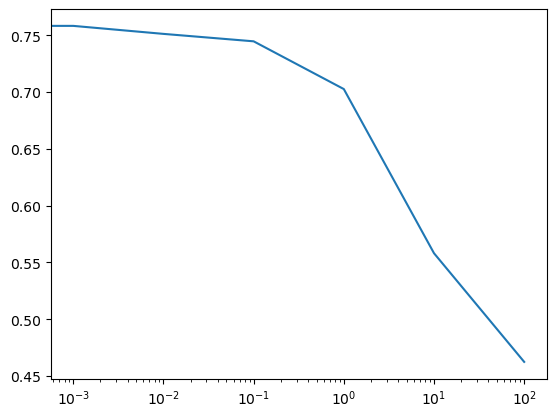

In [39]:
plt.plot(easy_results['param_model__alpha'], easy_results['mean_test_score'])
plt.xscale('log')

In [27]:
fine_tuned_results['param_model__max_depth'].unique()

array([None, 2, 6, 20], dtype=object)